**Does 10 predictions using XGBoost. Will spit out a csv of the ratios when run all the way through.**

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

/tmp/ipykernel_392659/3320276576.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data_file = "/home/timur/vesta/data/aligned.csv"

In [3]:
#McCullough Method
from sklearn.model_selection import train_test_split
df = pd.read_csv(data_file).fillna(-1)
df = df[df.power <= 10**5]
df = df.drop([col for col in df.columns if '__entry' in col], axis=1)
df = df.drop([col for col in df.columns if '__return' in col], axis=1)
df = df.drop([col for col in df.columns if '__begin' in col], axis=1)
df = df.drop([col for col in df.columns if '__end' in col], axis=1)
train_bench = "combined-benchmarks"
benchmarks = df.benchmark.unique()
ratios = {}
import tensorflow as tf


for bench in benchmarks:
    ratios[bench] = []
for i in range(0,10):
    for component in ["power"]:
        model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
        events_train = pd.DataFrame()
        events_test = {}
        power_train = pd.DataFrame()
        power_test = {}
        for bench in benchmarks:
            events_df_train = df[df.benchmark == bench]
            power_df_train = events_df_train[component]

            events_df_train = events_df_train.drop(["iteration","ts","benchmark","power"], axis=1)
            events_df_train = events_df_train.drop([col for col in events_df_train.columns if 'energy_component' in col], axis=1)
            if(len(events_df_train) <= 1):
                events_train = pd.concat([events_train, events_df_train])
                events_test[bench] = events_df_train
                power_train = pd.concat([power_train, power_df_train])
                power_test[bench] = power_df_train
                continue        

            events_train_b, events_test_b, power_train_b, power_test_b = train_test_split(events_df_train, power_df_train, test_size=.5)

            events_train = pd.concat([events_train, events_train_b])
            events_test[bench] = events_test_b

            power_train = pd.concat([power_train, power_train_b])
            power_test[bench] = power_test_b

        model.fit(events_train, power_train)
        for bench in benchmarks:
            prediction_energy = model.predict(events_test[bench])
            real_energy = power_test[bench]
            total_prediction_energy = prediction_energy.sum()
            total_actual_energy = real_energy.sum()

            ratio =  np.abs((total_actual_energy - total_prediction_energy) / total_actual_energy)
            ratios[bench].append(ratio)

2024-02-12 19:06:17.118936: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 19:06:17.147843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 19:06:17.147867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 19:06:17.148635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 19:06:17.154031: I tensorflow/core/platform/cpu_feature_guar

In [4]:
ratio_mean = pd.DataFrame(ratios).mean()
ratio_mean_df = pd.DataFrame(ratio_mean).rename(columns={0:"mean"})
ratio_mean_df["std"] = pd.DataFrame(ratios).std()
ratio_mean_df = ratio_mean_df.sort_index()
ratio_mean_df = ratio_mean_df.reset_index(names=["benchmark"])
ratio_mean_df.to_csv("/home/timur/vesta/data/scores.csv", index=False)

In [11]:
ratio_mean_df

,benchmark,mean,std
0,akka-uct,0.001377,0.000935
1,als,0.007038,0.004533
2,avrora,0.007282,0.000572
3,batik,0.007329,0.004069
4,biojava,0.040922,0.003621
5,chi-square,0.018024,0.016417
6,dec-tree,0.016266,0.015336
7,dotty,0.015971,0.015757
8,finagle-chirper,0.001419,0.001140
9,finagle-http,0.002701,0.002535


<Axes: xlabel='benchmark'>

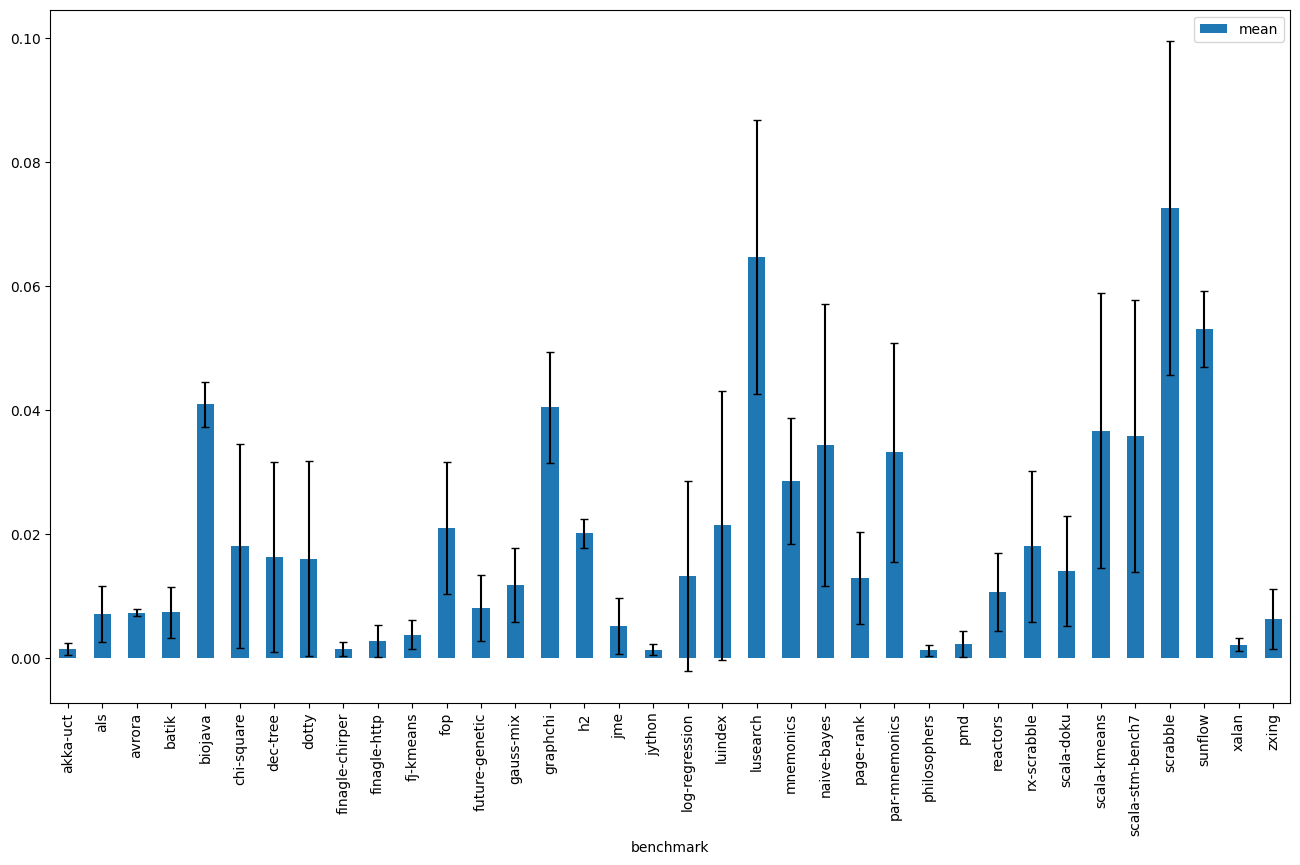

In [10]:
ratio_mean_df.plot.bar(x='benchmark', y='mean', yerr='std', figsize=(16, 9), capsize=3)